# Linear Regression techniques using MOSEK Fusion API


Regression is one of the most used techniques in finance, statistic, biology and in general any application where it is necessary to construct models that approximate input data.

The aim of this tutorial is two-fold:

1. to show some modeling techniques to define regression problems;
2. to show how to efficiently implement those problems using MOSEK Fusion API.


This tutorial is largerly based on:

    [1] Schmelzer, T., Hauser, R., Andersen, E., & Dahl, J. (2013). Regression techniques for Portfolio Optimisation using MOSEK. arXiv preprint arXiv:1310.3397.
    [2] Boyd, S., & Vandenberghe, L. (2004). Convex optimization. Cambridge university press.


The code is written in Python3 and uses the [MOSEK Fusion API](https://mosek.com/resources/doc) version 8.

# The basics

Our aim is to define a linear model that explain the relation of a set of $m$ given variables $x_1,\ldots,x_m$ (the *inputs*) and a dependent variable $y$ (the *output*). To this extent we assume that there exists a set of weights $w\in \mathbb{R}^{m}$ such that ideally

$$
y = x^T w,
$$

where $x=(x_1,\ldots,x_m)$.

In practice, we are given $n$ observations of the relation that links $x$ and $y$. We store them row-wise in a matrix $X\in \mathbb{R}^{n\times m}$. Corresponding outputs $y=(y_i,\ldots,y_n)$ are known as well. If the relation we want to describe is truly linear we can hope to solve the linear system

$$
X w =y.
$$

But usually this is not the case because


* in the real-world perfect linear model are fairly rare;
* $y_i$'s may be corrupted or noisy;
* we may want to include conditions on $w$, i.e. asking that $w\in W$ with $W$ some well define convex set.

Since our main interest is on conic optimization, we assume $W$ to be a conic representable set. 
For sake of simplicity we consider $W=\{w\in \mathbb{R}^m \}$. 

What we can do is to reduce the error that the linear model introduces. We define 

$$
r = Xw - y,
$$

as the *vector of residual*. Our aim is thus to reduce as much as possible some error function $\phi(\cdot)$ on $r$, i.e.

$$
\begin{array}{ll}
 \min & \phi(r)\\ s.t.&\\
  & r = Xw - y, \\
  & w\in W.
\end{array}
$$

The choice of the function $\phi(\cdot)$ determines the way errors on the residuals are weighted. Typical choices are:

* $l_p-$norm 
* *Chebyshev* norm (also known as *Min-max*)
* *Deadzone-linear* 
* *$k$-largest residuals*

In the following we will provide the penalty functions definition and implementations. We first start including relevant modules and with some helper functions.

In [1]:
from mosek.fusion import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('savefig',dpi=120)

def plot(title,err,nbins,color):
    plt.xlim([min(err),max(err)])
    plt.title(title)
    plt.grid()
    plt.hist( err,nbins,facecolor=color,histtype='stepfilled')
    plt.show()

def ddot(x,y): return sum([ xx*yy for xx,yy in zip(x,y)])
def error(X,w,y): return [ ddot(X[i], w ) - y[i] for i in range(len(y)) ]

def print_err(name,ee):
    n= len(y)
    absee= [ abs(e) for e in ee]
    print("%s avg= %f ; |min| = %f ; |max| = %f ; |avg| = %f"%(name, sum(ee)/n, min(absee), max(absee), sum(absee)/n))

nbuckets = 20

We also need some dat to make a simple regression. 

In [2]:
import random as rnd 

n = 500
m = 2
e= 1

X = [ [rnd.gauss(0.0,e) for j in range(m)] for i in range(n)]
y = [ sum(X[i])+rnd.gauss(0.0,e/2.) for i in range(n)]


## $l_p$ norm

The $l_p$ norm

$$\phi(r) = \| r \|_p = \left( \sum_i |r_i|^p \right)^{1/p}$$

Typical choices are 


* $p=1$, i.e. the some of absolute values, i.e.

$$
\phi(r) = \sum_i |r_i|
$$

* $p=2$, i.e. the Euclidean norm,

$$
\phi(r) = \sqrt{ \sum_i r_i^2 } 
$$

The conic model for the $l_1$ norm is

$$
\begin{array}{lll}
\min & \sum_i t_i\\
s.t. &\\
& t_i \geq | x_i^T w - y_i|,& \forall i=1,\ldots,n\\
& w\geq 0
\end{array}
$$

The absolute value can be converted in a pair of linear constraints, yielding the following compact formulation:

$$
\begin{array}{ll}
\min & \sum_i t_i\\
s.t. &\\
& t \geq Xw - y\\
& t \geq y - Xw\\
& w\geq 0.
\end{array}
$$

Implementing the model in Fusion only takes few lines:

In [3]:
def lsq_l1_norm(X,y,n,m):
       
    with Model() as M:
           
        w = M.variable(m, Domain.unbounded())
        t = M.variable(n, Domain.unbounded())
            
    
        M.constraint( Expr.sub(Expr.mul(X,w),t), Domain.lessThan(y))
        M.constraint( Expr.add(t,Expr.mul(X,w)), Domain.greaterThan(y))
            
        M.objective(ObjectiveSense.Minimize, Expr.sum(t))
    
        M.solve()
    
        return w.level()

Similarly, the $l_2$ norm model reads

$$
\begin{array}{ll}
\min_{w,t} & t\\
s.t. &\\
& t \geq \| X w - y||_2.
\end{array}
$$

Thanks to the use of second order cones, we can minimize directly the $2$-norm with no issue from non-differentiability at the origin:

$$
\begin{array}{ll}
\min_{w,t} & t\\
s.t. &\\
& (t, X w - y) \in \mathcal{Q^{n+1}}.
\end{array}
$$


In [4]:
def lsq_l2_norm(X,y,n,m):
    
    with Model() as M:
           
        w = M.variable(m, Domain.unbounded())
        t = M.variable(1, Domain.unbounded())
    
        M.constraint(Expr.vstack(t, Expr.sub( Expr.mul(X,w), y)), Domain.inQCone(1,n+1))
            
        M.objective(ObjectiveSense.Minimize, t)
       
        M.solve()
    
        return w.level()

Notice how we use the method `Var.repeat` to logically repeat $t$ and obtain a vector with $n$ components.

l1 :  avg= 0.000609 ; |min| = 0.000000 ; |max| = 1.396384 ; |avg| = 0.375023
l2 :  avg= 0.000160 ; |min| = 0.000365 ; |max| = 1.391281 ; |avg| = 0.375058


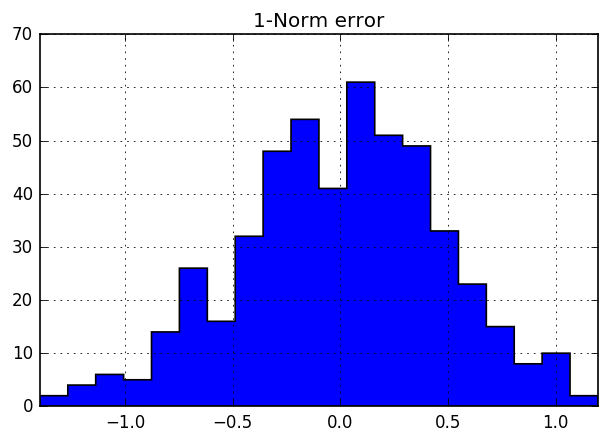

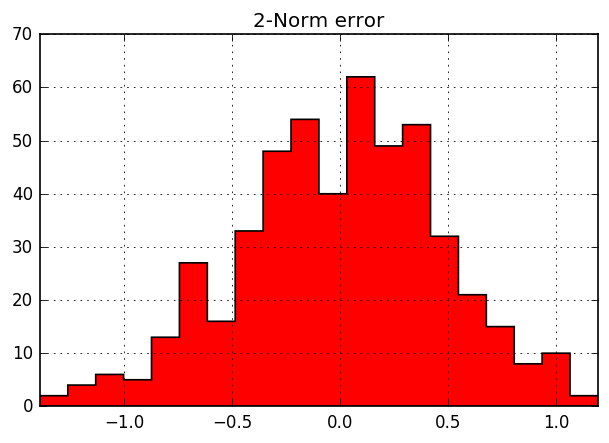

In [5]:
w1  = lsq_l1_norm(X,y,n,m)
w2  = lsq_l2_norm(X,y,n,m)

err1 = error(X,w1,y)
err2 = error(X,w2,y)

print_err('l1 : ', err1)
print_err('l2 : ', err2)

plot('1-Norm error',err1,nbuckets,'blue')
plot('2-Norm error',err2,nbuckets,'red')


## The $3/2$ regression 

We consider a penalty function of the form

$$\phi(r) = \sum_i | r_i |^{3/2}.$$

This is a typical case where conic quadratic optimization shines. The model is therefore:

$$
 \begin{array}{lll}
  \min & \sum_i t_i                        &             \\
      & (t_i, [Xw-y]_i)\in \mathcal{Q^2}  & i=1,\ldots,m, \\
      & (s_i,z_i, t_i) \in \mathcal{Q_r^3}& i=1,\ldots,m,\\
      & (1/8,t_i, s_i) \in \mathcal{Q_r^3}& i=1,\ldots,m.
 \end{array}
$$

A compact Fusion implementation is 

In [6]:
def lsq_32_reg(X,y,n,m):
    
    with Model() as M:
        w = M.variable('w', m)
        
        t = M.variable('t', m, Domain.unbounded())
        s = M.variable('s', m, Domain.unbounded())
        z = M.variable('z', m, Domain.unbounded())
    

        M.constraint(Expr.vstack( t, Expr.sub(Expr.mul(X,w), y)), Domain.inQCone())        
        M.constraint(Expr.hstack(s, z, t), Domain.inRotatedQCone())
        M.constraint(Expr.hstack(Expr.constTerm(m,1./8.),t, s), Domain.inRotatedQCone())
    
        M.objective(ObjectiveSense.Minimize, Expr.sum(t))

        M.solve()
    
        return w.level()

Note in particular how we can define set of cones from horizontally stacked vectors: Fusion will generate a cone for each rows!

3/2 linear regression:  avg= 0.000160 ; |min| = 0.000365 ; |max| = 1.391281 ; |avg| = 0.375058


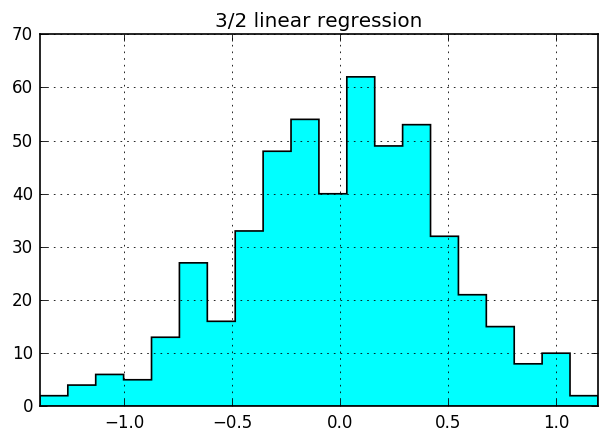

In [7]:
w3_2  = lsq_32_reg(X,y,n,m)


err3_2 = error(X,w3_2,y)


print_err('3/2 linear regression: ', err3_2)

plot('3/2 linear regression',err3_2,nbuckets,'cyan')

# Deadzone-linear

This approach steams from the $l_1$ norm approximation, but ignoring small errors. Given a threshold $a\geq 0$, we define 

$$ \phi(r) = \sum_i \max(0, |r_i|-a )$$


The conic optimization model takes the form:

$$
\begin{array}{lll}
\min &  \sum_i t_i\\
s.t. &\\
& t_i \geq | x_i^T w - y_i|-a,& \forall i=1,\ldots,n\\
& t\geq 0 
\end{array}
$$ 

Again, removing the absolute value we obtain in compact form:

$$
\begin{array}{ll}
\min & t\\
s.t. &\\
& t\cdot e \geq Xw - y - a\\
& t \cdot e \geq y - Xw - a.
\end{array}
$$

where $e$ is a vector of all ones.


In [8]:
def lsq_deadzone_linear(X,y,n,m,a):
    
    if a<0.: return None
    
    with Model() as M:
           
        w = M.variable(m)
        t = M.variable(n)
        
        y_plus_a  = [y[i]+a for i in range(n)]
        y_minus_a = [y[i]-a for i in range(n)]
    
       
        M.constraint( Expr.sub( Expr.mul(X,w), t), Domain.lessThan(y_plus_a))
        M.constraint( Expr.add( t, Expr.mul(X,w)), Domain.greaterThan(y_minus_a))
        
        M.objective(ObjectiveSense.Minimize, Expr.sum(t))
    
        M.solve()
    
        return w.level()

Dead-zone linear regression:  avg= 0.000609 ; |min| = 0.000000 ; |max| = 1.396384 ; |avg| = 0.375023


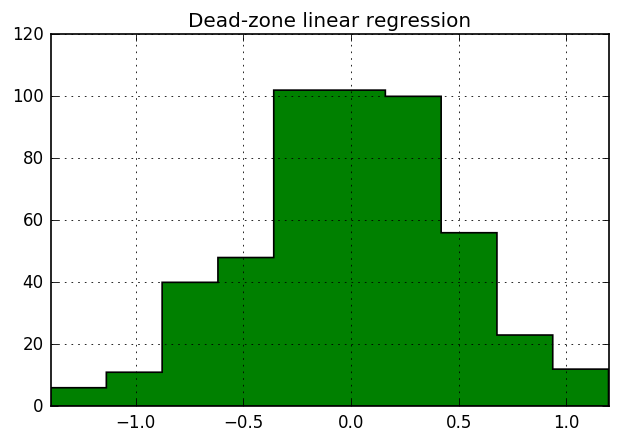

In [9]:
wdzl  = lsq_deadzone_linear(X,y,n,m,1.)


errdzl = error(X,wdzl,y)


print_err('Dead-zone linear regression: ', errdzl)

plot('Dead-zone linear regression',errdzl,10,'green')

## Chebyshev Approximation

Sometimes referred as the *minmax* approximation, it uses 

$$\phi(r) = \max_i( |r_i| ) = \|r\|_{\infty}$$

as penalty function. It is a limit case of $l_p-$norm as $p\rightarrow \infty$. The effect is to only look at the largest error in absolute value. The formulation of our problem is therefore

$$
\begin{array}{lll}
\min & t\\
s.t. &\\
& t \geq | x_i^T w - y_i|,& \forall i=1,\ldots,n.
\end{array}
$$

The absolute value can be converted in a pair of linear constraints, yielding the following compact formulation:

$$
\begin{array}{ll}
\min & t\\
s.t. &\\
& t\cdot e \geq Xw - y\\
& t\cdot e \geq y - Xw.
\end{array}
$$

where $e$ is a vector of all ones. This formulation is easily implemented in Fusion:


In [10]:
def lsq_minmax_norm(X,y,n,m):
    
    with Model() as M:
           
        w = M.variable(m)
        t = M.variable(1, Domain.unbounded())
    
        one_t= Var.repeat(t,n)
    
        M.constraint( Expr.sub( Expr.mul(X,w), one_t), Domain.lessThan(y))
        M.constraint( Expr.add( one_t, Expr.mul(X,w)), Domain.greaterThan(y))
        
        M.objective(ObjectiveSense.Minimize, t)
    
        M.solve()
    
        return w.level()

Notice how we use `Variable.repeat` to logically repeat $t$.

Minimax regression:  avg= -0.004430 ; |min| = 0.000766 ; |max| = 1.344985 ; |avg| = 0.380305


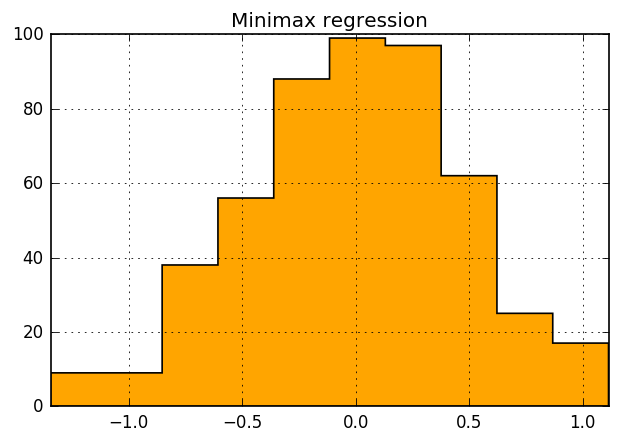

In [11]:
wmm = lsq_minmax_norm(X,y,n,m)


errmm = error(X,wmm,y)


print_err('Minimax regression: ', errmm)

plot('Minimax regression',errmm,10,'orange')



# Sum of the largest $k$ residuals

The penalty function $\phi$ is defined as 

$$\phi(u) = \sum_{i=1}^k | r_{[i]} |, $$

where the notation $r_{[i]}$ indicates the $i$-th element of $r$ sorted. It can be shown that the corresponding regression problem is indeed a linear program:


$$
\begin{array}{ll}
\min & z\\
& r = Xw -y \\
& t \geq r\\
& t \geq -r\\
& kt + \mathbb{1}^t u \leq z\\
& s \mathbb{1} + u \geq t\\
& u\geq 0,\\
& u\in \mathbb{R}^n,t\in \mathbb{R}.
\end{array}
$$

More details can be found in `[2]`. The code follows:


In [12]:
def lsq_k_largest(X,y,n,m,k):
    
    with Model() as M:
        
        w = M.variable(m, Domain.unbounded())
        r = M.variable(n, Domain.unbounded())
        t = M.variable(n, Domain.greaterThan(0.))
        z = M.variable(1, Domain.unbounded())
        s = M.variable(1, Domain.unbounded())
        u = M.variable(n, Domain.greaterThan(0.))
                  
        M.constraint(Expr.sub(Expr.mul(X,w),r), Domain.equalsTo(y))
        
        M.constraint( Expr.sub(t,r), Domain.greaterThan(0.))
        M.constraint( Expr.add(t,r), Domain.greaterThan(0.))
        
        M.constraint( Expr.add([Expr.mul(float(k),s),Expr.sum(u),Expr.neg(z)]), Domain.lessThan(0.))
        
        M.constraint( Expr.sub(Expr.add(Var.repeat(s,n),u), t), Domain.greaterThan(0.))
        
        M.objective(ObjectiveSense.Minimize, z)
        M.solve()
    
        return w.level()

K-largest regression:  avg= 0.003448 ; |min| = 0.000591 ; |max| = 1.428136 ; |avg| = 0.376393


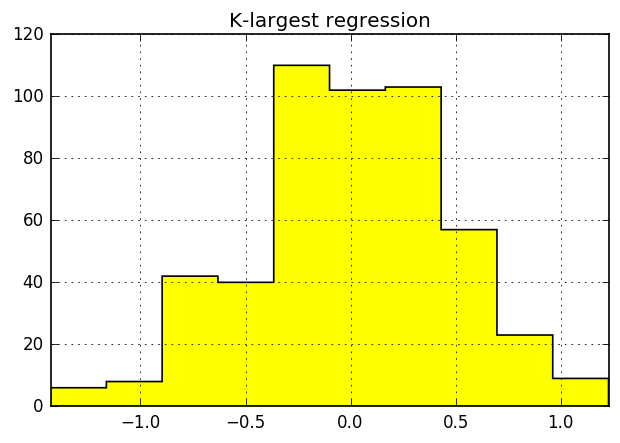

In [ ]:
wkl = lsq_k_largest(X,y,n,m,10.)


errkl = error(X,wkl,y)


print_err('K-largest regression: ', errkl)

plot('K-largest regression',errkl,10,'yellow')



# Some observations

## Modeling

All the regression models presented in this tutorial lead to either a linear or a second-order conic optimization problem. That means that

* they can be solved in polynomial time by standard optimization algorithms;

* add additional (conic)constraints on the weights can be easily included;

* sparsity in the input, i.e. in $X$, can be easily handled and usually leads to great savings in time and memory;

* it is a good rule of thumb to try to solve also the dual formulation, which can be sometimes faster.

For large scale models, it may be necesary to move from **Fusion** to the lower-level API in order to save memory and reduce model building time.


## Computational time

To conclude, let us see the differences in terms of running time:

In [ ]:
%timeit w1  = lsq_l1_norm(X,y,n,m)
%timeit w2  = lsq_l2_norm(X,y,n,m)
%timeit w32 = lsq_32_reg(X,y,n,m)
%timeit wmm = lsq_minmax_norm(X,y,n,m)
%timeit wkl = lsq_k_largest(X,y,n,m, 10)
%timeit wdzl= lsq_deadzone_linear(X,y,n,m, 0.15)

10 loops, best of 3: 100 ms per loop
10 loops, best of 3: 38.2 ms per loop


As expected, the running time is roughly the same for all formulations.

# Conclusions

In this tutorial we have presented some typical linear regression techiniques. They lead to conic optimization problems that are 

* easy to formulate using MOSEK Fusion API;

* solvable by robust and state-of-the-art algorithms in polynomial time;

* flexible as more constraints can be included.

Do you want to know more? Check out other Notebook, or contact us <a href="mailto:info@mosek.com"> MOSEK </a>.



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>
The MOSEK collection of iPython Notebook by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" 
   rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.
Based on a work at <a  
   xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/MOSEK" rel="dct:source">https://github.com/MOSEK</a>.
Permissions beyond the scope of this license may be available at <a 
   xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" rel="cc:morePermissions">www.mosek.com</a>.
